In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

## Load and Examine the data

In [2]:
data = pd.read_csv("../data/1_set.csv")

In [3]:
data.sample(5)

,tweet,hate,offensive,ok
15807,RT @Jigga504: &#8220;@mleew17: u pretty but da...,0,1,0
37845,I really want hotcakes and pancakes so bad! #MKR,0,0,1
6954,@sajeffress tag me pussy ill fite u,0,1,0
25838,@JRehling Since Muslims don't speak out agains...,0,0,1
40760,#stopwadhwa2015 @theonion wrote an article abo...,0,0,1


In [4]:
cols_target = ['hate', 'offensive', 'ok']

In [5]:
data.describe()

,hate,offensive,ok
count,40959.000000,40959.000000,40959.000000
mean,0.119144,0.587661,0.496570
std,0.323961,0.492262,0.499994
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [6]:
data['tweet'].isnull().sum()

0

In [7]:
print(data[cols_target].sum())

hate          4880
offensive    24070
ok           20339
dtype: int64


length of the text in the tweets:

In [8]:
data['text_length'] = data['tweet'].apply(lambda x:len(str(x)))

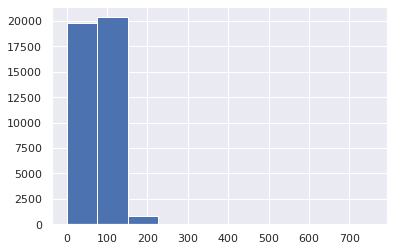

In [9]:

#histogram plot for text length
sns.set()
data['text_length'].hist()
plt.show()

Most of the text is less than 300 chars

Checking what is going on with the data:

In [10]:
all_words = []
for tweet in data['tweet']:
    for word in tweet.split():
        all_words.append(word)
        
def word_freq(list):
    """getting the freq of words
    input: a list of words
    output: dict with items of the list as key and
    their freq in the list as the value"""
    words_dict = {}
    for word in list:
        words_dict[word] = words_dict.get(word,0)+1
    return words_dict

sort_orders = sorted(word_freq(all_words).items(), key=lambda x:x[1], reverse=True)
for i in sort_orders[0:10]:
    print(i)

('a', 12583)
('the', 11613)
('RT', 10837)
('to', 9157)
('I', 9153)
('bitch', 6685)
('you', 6559)
('and', 6196)
('is', 5570)
('of', 5352)


# Cleaning up the text

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's","what is", text)
    text = re.sub(r"rt", '',text)
    text = re.sub(r"\'ve","have", text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"i'm","i am", text)
    text = re.sub(r"\'re'","are", text)
    text = re.sub(r"\'d'","would",text)
    text = re.sub(r"\'ll'", "will", text)
    text = re.sub(r"\'scuse'", "excuse", text)
    text = re.sub("\W",' ', text)
    text = re.sub('\s+',' ',text)
    text = text.strip(' ')
    return text

import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [12]:
data['tweet'] = data['tweet'].map(lambda x: clean_text(x))

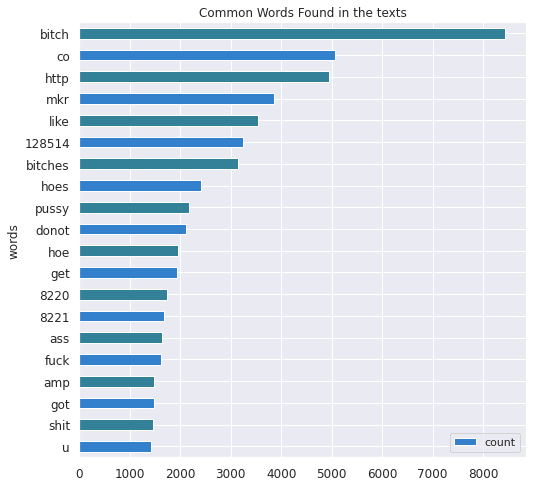

In [13]:
all_words = []
for tweet in data['tweet']:
    for word in tweet.split():
        all_words.append(word)
        
def word_freq(list):
    """getting the freq of words
    input: a list of words
    output: dict with items of the list as key and
    their freq in the list as the value"""
    words_dict = {}
    for word in list:
        words_dict[word] = words_dict.get(word,0)+1
    return words_dict
words_no_stop = [i for i in all_words if not i in stop_words]

sort_orders = sorted(word_freq(words_no_stop).items(), key=lambda x:x[1], reverse=True)

dataframe = pd.DataFrame(sort_orders[:20],
                        columns=['words','count'])
fig, ax = plt.subplots(figsize=(8,8))
dataframe.sort_values(by='count').plot.barh(x='words',
                                           y='count',
                                           ax=ax,
                                           color=[(0.2,0.5,0.8),(0.2,0.5,0.6)],
                                            fontsize=12)
ax.set_title('Common Words Found in the texts')
plt.show()

In [14]:
data['tweet']

0        mayasolovely as a woman you shouldnot complain...
1        mleew17 boy dats cold tyga dwn bad for cuffin ...
2        urkindofbrand dawg 80sbaby4life you ever fuck ...
3           c_g_anderson viva_based she look like a tranny
4        shenikarobes the shit you hear about me might ...
                               ...                        
40954           scaryjen alfuriuskj nayadrikj undead 4ever
40955                                  here s a suggestion
40956    ardiem1m alfonso_araujog maxblumenthal oldkhay...
40957    oh i knew it fuuuck more restaurants ok i said...
40958    kickyfast bonegolem totalbiscuit srhbutts nice...
Name: tweet, Length: 40959, dtype: object

In [15]:
data = data.drop('text_length', axis=1)
data.shape

(40959, 4)

In [16]:
X = data.tweet
Y = data.drop('tweet', axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


## Vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=400, stop_words = 'english')
vect

TfidfVectorizer(max_features=400, stop_words='english')

In [18]:
X_dtm = vect.fit_transform(x_train)
X_dtm_test = vect.fit_transform(x_test)
X_dtm


<32767x400 sparse matrix of type '<class 'numpy.float64'>'
	with 110176 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg =LogisticRegression(tol = 0.01,C=1.0, max_iter=10000)

for label in cols_target:
    print('...Processing {}'.format(label))
    y = y_train[label]
    logreg.fit(X_dtm,y)
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    y_test_2 = y_test[label]
    logreg.fit(X_dtm_test,y_test_2)
    y_pred_X_test = logreg.predict(X_dtm_test)
    print('Testing accuracy is {}'.format(accuracy_score(y_test_2, y_pred_X_test)))

...Processing hate
Training accuracy is 0.8955961790826136
Testing accuracy is 0.89501953125
...Processing offensive
Training accuracy is 0.8880886257515183
Testing accuracy is 0.90087890625
...Processing ok
Training accuracy is 0.9530014954069643
Testing accuracy is 0.9552001953125


## Export model

In [20]:
import pickle
pickle.dump(logreg,open("LR.pkl","wb"))

## Test Model

In [21]:
with open('LR.pkl','rb') as f:
    model = pickle.load(f)

In [22]:
print(model.predict(X_dtm_test))

[0 0 0 ... 1 1 1]


In [23]:
def add_feature(X, feature_to_add):

    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [24]:
for label in cols_target:
    
    print('...Processing {}'.format(label))
    y = y_train[label]
    logreg.fit(X_dtm,y)
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    X_dtm = add_feature(X_dtm, y)
    print('TShape of X_dtm is now {}'.format(X_dtm.shape))
    
    y_test_2 = y_test[label]
    logreg.fit(X_dtm_test,y_test_2)
    y_pred_X_test = logreg.predict(X_dtm_test)
    print('Training accuracy is {}'.format(accuracy_score(y_test_2, y_pred_X_test)))
    
    X_dtm_test = add_feature(X_dtm_test, y_test_2)
    print('TShape of X_dtm_test is now {}'.format(X_dtm_test.shape))

...Processing hate
Training accuracy is 0.8955961790826136
TShape of X_dtm is now (32767, 401)
Training accuracy is 0.89501953125
TShape of X_dtm_test is now (8192, 401)
...Processing offensive
Training accuracy is 0.9633167516098514
TShape of X_dtm is now (32767, 402)
Training accuracy is 0.96337890625
TShape of X_dtm_test is now (8192, 402)
...Processing ok
Training accuracy is 0.9933164464247566
TShape of X_dtm is now (32767, 403)
Training accuracy is 0.9937744140625
TShape of X_dtm_test is now (8192, 403)
